Here, I plot Citi Bike trips from the month of August 2019 over a map of New York City. The Citi Bike dataset only contains the duration and location of the beginning/end of each ride, so I will display their appromixate location, assuming they are moving in a straight line at a constant velocity.

I do not plot any rides that begin/end at the same stop. I chose to do this because these are rides that will be poorly approximated by the method above. Whereas I have some idea about the route that somebody who dropped their bike off at a different stop took, there is no way to know where somebody who returned their bike to the original station traveled during their ride.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Convert time of ride from seconds to minutes, rounded down
def sec_to_min(seconds):
    return int(seconds/60)

#Adjust time to represent how many minutes into month
def fix_time_formatting(time):
    day = int(time[8:10])
    hour = int(time[11:13])
    minute = int(time[14:16])
    return (1440*(day-1) + 60*hour + minute)

#Import data into df 
df = pd.read_csv('201808-citibike-tripdata.csv')
df['tripduration'] = df['tripduration'].apply(sec_to_min)
df['mins_into_month'] = df['starttime'].apply(fix_time_formatting)

<IPython.core.display.Javascript object>


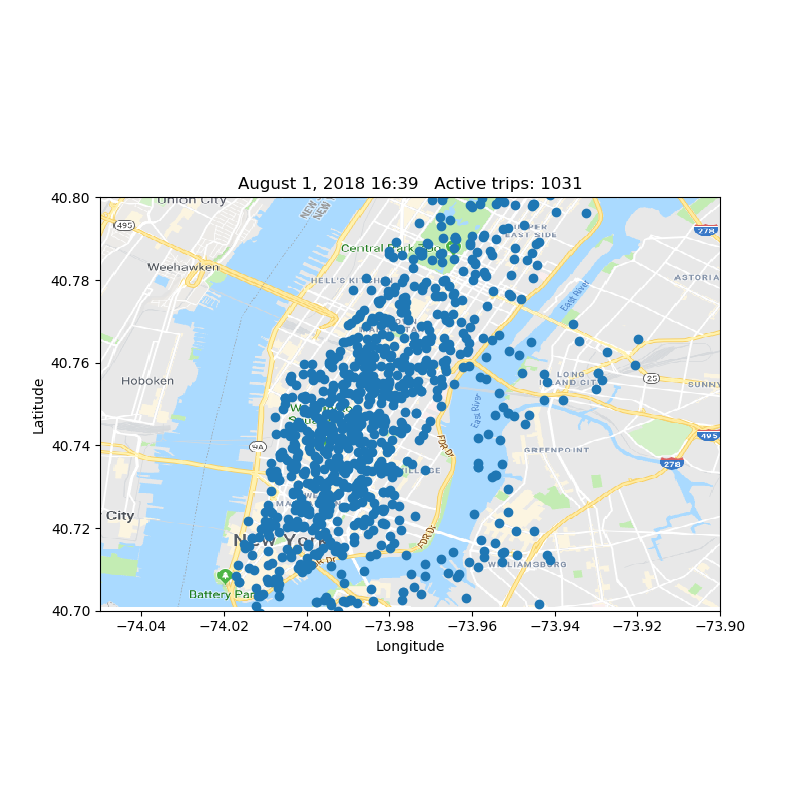

In [2]:
%matplotlib notebook
import matplotlib.image as mimage
nyc_area_map = mimage.imread('NYCmap.png')

#Turns a row from the df into a list for plotting
#Velocity is calculated based on moving at const speed from start->end
def rideify(ride):
    duration = int(ride['tripduration'])
    initial_position_x = float(ride['start station longitude'])
    initial_position_y = float(ride['start station latitude'])
    final_position_x = float(ride['end station longitude'])
    final_position_y = float(ride['end station latitude'])
    velocity_x = (final_position_x - initial_position_x)/float(duration)
    velocity_y = (final_position_y - initial_position_y)/float(duration)
    return [initial_position_x, initial_position_y, velocity_x, velocity_y, duration+1]

#Prepares a list of X,Y coordinates from each ride for plotting
def process_rides_for_plot(trips):
    X = []
    Y = []    
    for trip in trips:
        X.append(trip[0])
        Y.append(trip[1])
        trip[4] -= 1
    return [X,Y]

#Updates the position coordinates for each ride
def move_bicycles(trips):
    updated_trips = []
    
    for trip in trips:
        if trip[4] > 0:
            trip[0] += trip[2]
            trip[1] += trip[3]
            updated_trips.append(trip)
    return updated_trips

#Get the day:hour:min from how many minutes into the month
def get_date(min_into_month):
    day = str(1 + int(min_into_month/1440))
    hour = str(int((min_into_month%1440)/60))
    minute = ('0' + str(int((min_into_month%1440)%60)))[-2:]
    return(day + ', 2018 ' + hour + ':' + minute)

#Prepare plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
            
#List of current trips
active_trips = list()

#Plot trips
mins_into_month = 0
while mins_into_month < 1000:
    #Add trips that started on a given minute
    rides = df.loc[df['mins_into_month'] == mins_into_month]
    for index, row in rides.iterrows():
        #Only plot trips that start/end at different stations
        if int(row['start station id']) != int(row['end station id']):
            active_trips.append(rideify(row))
    
    #Assemble trips into X,Y coordinates for plotting
    [X,Y] = process_rides_for_plot(active_trips)
    
    #Build and draw plot
    ax.clear()
    #Bicycle marker?
    ax.scatter(X,Y)#,500, marker="")
    plt.title('August ' + get_date(mins_into_month) + '   Active trips: ' + str(len(active_trips)))
    plt.imshow(nyc_area_map, extent=[-74.060182, -73.875412, 40.700849, 40.822868], alpha=1)
    plt.ylim(40.7,40.8)
    plt.xlim(-74.05, -73.9)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    fig.canvas.draw()
    
    #Save frames from plot to make video
    #plt.savefig('Frame' + str(mins_into_month) + '.png')   
    
    #Adjust bicycle positions and remove finished trips from active trips list
    active_trips = move_bicycles(active_trips)
    
    #Move one minute forward
    mins_into_month += 1

A demo of the bicycle plots during part of a Monday morning rush hour can be seen in the CitiBike demo.avi file.